In [1]:
%run Latex_macros.ipynb

<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import transform_helper

sph = transform_helper.StockReturn_Pooling_Helper()

# Create plots for Fundamental Assumption
ssm = transform_helper.StockPrice_shiftedMean_Helper()
ss_df = ssm.gen_prices(.001, .02, [10, 20], num_returns=252)
fig_data, axs_data = ssm.plot_data(ss_df, visible=False)
fig_segs, axs_segs = ssm.plot_segments(ss_df, visible=False)

# Create plots for shifted price
sph = transform_helper.ShiftedPrice_Helper()
series_over_time = sph.gen_data(m=30)

fig_sp, ax_sp = plt.subplots(1,1, figsize=(12,6) )
_= sph.plot_data(series_over_time, ax=ax_sp)

plt.close(fig_sp)

# Create plots for relative price
rph = transform_helper.RelativePrice_Helper()
series = rph.gen_data(attrs=["area", "price"])

labels=[ "USD", "USD", "RMB", "HKD" ]

fig_rp, ax_rp = plt.subplots(1,1, figsize=(12,6))
_= rph.plot_data(series, ax=ax_rp, labels=labels, xlabel="Area", ylabel="Price (local)")

plt.close(fig_rp)

In [4]:
# Geron Housing Data example
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [5]:
fetch_housing_data()

In [6]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()

# Non-homogeneous data: make it (more) Homogeneous

## Normalization via z-score

Let's consider a simple dataset with examples that are drawn from two different groups

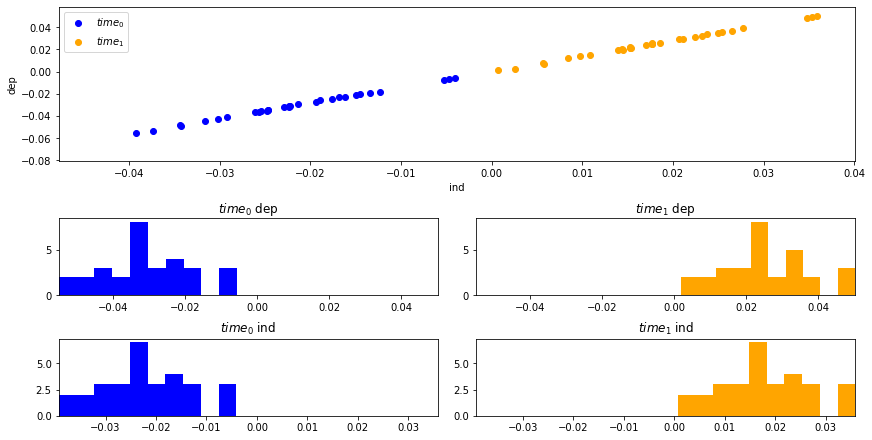

In [7]:
sph = transform_helper.StockReturn_Pooling_Helper()

means = [ -.02, +.02 ]
s = .16/(252**.5)

df_2means = sph.gen_returns(means, [s, s])

_= sph.plot_data(df_2means)

From the top graph: we can see that there is a constant linear relationship
- between target "dep" and feature "ind"
- both within groups and across groups

From the second and third rows, we see the distribution of features and targets
- has same shape between groups
- with different means

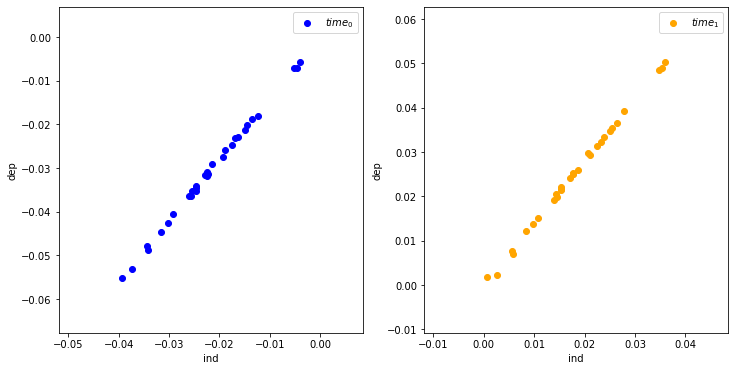

In [8]:
_= sph.plot_segments(df_2means)

Given the simple linear relationship intra-group
- No harm would come from pooling
- Even though the pooled data comes from distinct groups

*However*: it the intra-group relationship was more complex (e.g., a curve)
- pooling would be less successful

So although this example may be over-simplified, we still try to make the distinct groups look similar.

Let's normalize each group
- for each variable: turn values into z-scores
    - subtract variable mean, divide by variable standard deviation

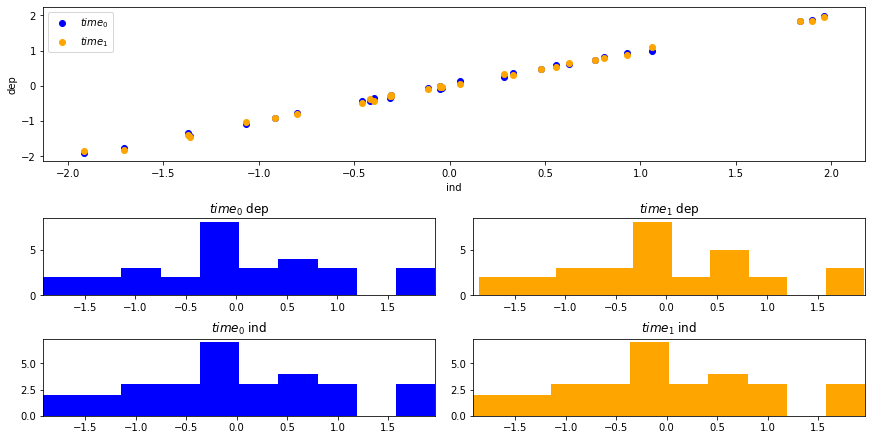

In [9]:
df_2means_norm = sph.normalize_data(df_2means)
_= sph.plot_data(df_2means_norm)

You can now see that the two groups are
- congruent in the top joint plot
- have same distributions in the second and third rows

Non-homogeneous groups made homogeneous !

We can make the separation between groups less trivial by also having different standard deviations per group.

Here's what the data looks like

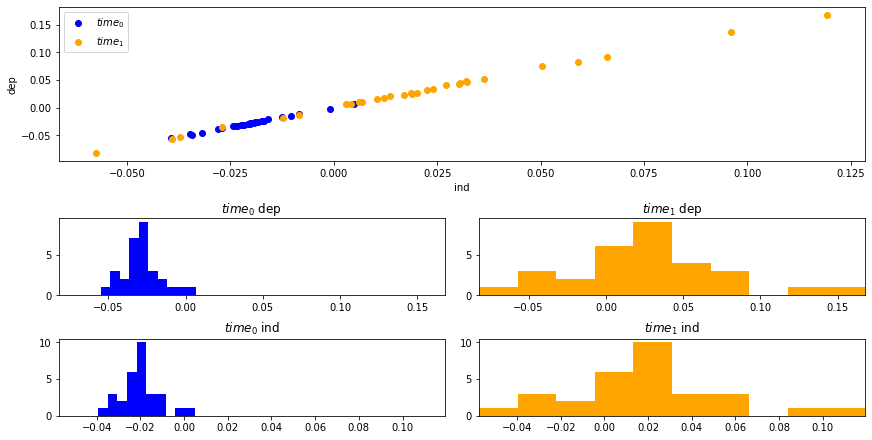

In [10]:
df_2means_2sdevs = sph.gen_returns(means, [s, 4*s])

_= sph.plot_data(df_2means_2sdevs)

Again: normalization does the trick

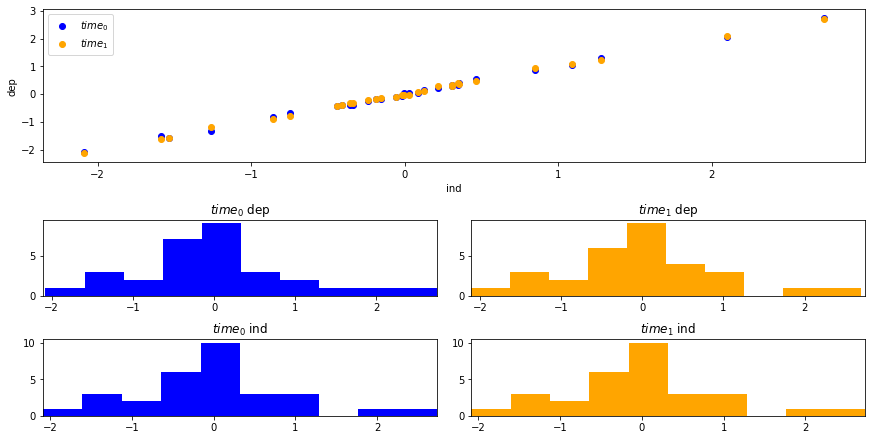

In [11]:
df_2means_2sdevs_norm = sph.normalize_data(df_2means_2sdevs)
_= sph.plot_data(df_2means_2sdevs_norm)

### Pooled over time alternate method: normalization

Let's revisit our "pooled over time" dataset.

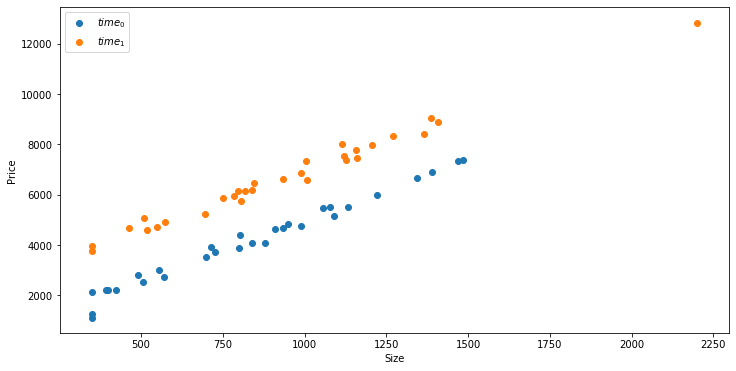

In [12]:
sph = transform_helper.ShiftedPrice_Helper()
series_over_time = sph.gen_data(m=30)

fig, ax = plt.subplots(1,1, figsize=(12,6) )
_= sph.plot_data(series_over_time, ax=ax)


We had previously addressed this by adding a missing feature
- distinct intercept per group
- by adding a "group indicator" feature

$$
\begin{array}[lll]\\
\y & = & \Theta_{(\text{time}_0)} * \text{Is}_0 + \Theta_{(\text{time}_1)} * \text{Is}_1  + \Theta_1 * \x \\
\end{array}
$$
- after addressing the "dummy variable" trap, the equation is of the form
$$
\y  =  \Theta_0 + \Theta_1 * \x
$$
We show an alternate solution using a (trivial) standardization


We will standardize both the target $\y$ and the single feature $\x$
- transform each to mean $0$
$$
\begin{array} \\
\y' & = & \y - \bar \y \\
\x' & = & \x - \bar \x \\
\end{array}
$$
- no scaling by volatility

Model equation
$$
\y' = \Theta'_0 + \Theta'_1 * \x'
$$

Here is the math behind this "de-meaning" transformation. 

If
$$
\y  =  \Theta_0 + \Theta_1 * \x
$$
then
$$
\begin{array} \\
\y^\ip & = & \Theta_0 + \Theta_1 * \x^\ip & \text{hypothesize linear relationship} \\
\frac{1}{m} \sum_i { \y^\ip } & =  &\frac{1}{m} \sum_i { (\Theta_0 + \Theta_1 * \x^\ip) } & \text{sum over all examples, divide by no. of examples }\\
\bar{\y} & = & \Theta_0 + \Theta_1 * \bar\x & \text{definition of average} \\
\Theta_0 & = & \bar\y - \Theta_1 * \bar\x &  \text{re-arrange terms} \\
\end{array}
$$

When $\bar \x = 0$ (as is the case for $\bar \x'$)
- $\Theta_0 = \bar \y'$


That is: we have transformed the two groups so as to have a common intercept.

Here is a little code to demonstrate this

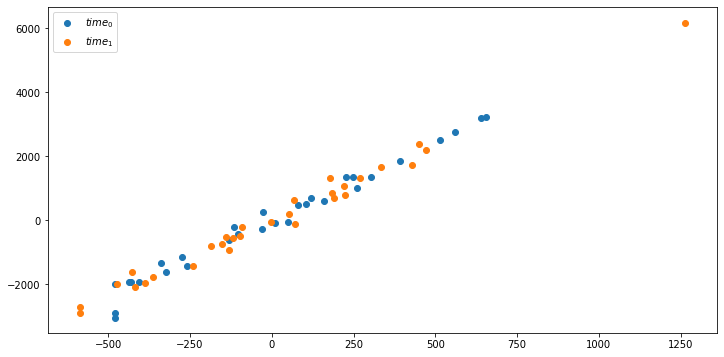

In [13]:


fig, ax = plt.subplots(1,1, figsize=(12,6) )

demean_x0 = sph.x0 - sph.x0.mean()
demean_x1 = sph.x1 - sph.x1.mean()

_= ax.scatter(demean_x0, sph.y0 - sph.y0.mean(), label="$time_0$")
_= ax.scatter(demean_x1, sph.y1 - sph.y1.mean(), label="$time_1$")
_= ax.legend()



Now it looks like each group comes from the same distribution.
- We can pool the observations from the two groups

## Normalization by uncovering the hidden relationship

Consider the following multi-group data (our multiple geography pooling of data)
- house price as a function of size
- in different geographies

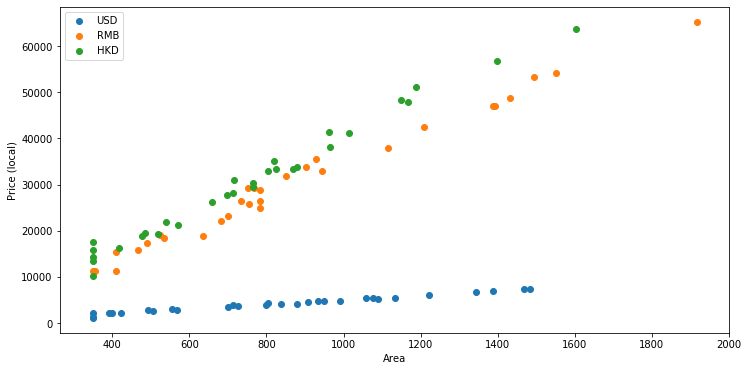

In [14]:
fig_rp

There is clearly a linear relationship intra-group, but the slope differs between groups (local currencies).

The apparent diversity in the target may obscure a simple relationship that is common to all groups

Let's re-denominate the target in a common unit.
- Let the target of example $i$ in group $g$ be
$$\y^\ip_{(\text{group}_g)}$$
- Change the units in which $\y^\ip_{(\text{group}_g)}$ is expressed
- Into a common unit
- Via an "exchange rate" equal to the slope of group $g$
$$
\beta_{(\text{group}_g)}
$$
- yielding
$$\tilde{\y}^\ip_{(\text{group}_g)} = \frac{\y^\ip_{(\text{group}_g)}}{ \beta_{(\text{group}_1)}}$$

If we do this for each group (separately) the data becomes homogeneous !

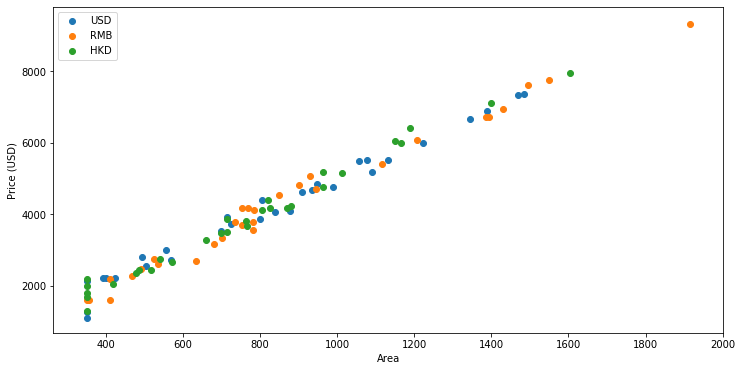

In [15]:
# Relative price levels
rel_price = rph.relative_price()

# Normalize the price of each series by the relative price        
series_normalized = [ series[i]/(1,rel_price[i]) for i in range(len(series))]

fig_rp_norm, ax_rp_norm = plt.subplots(1,1, figsize=(12,6))
_= rph.plot_data(series_normalized, ax=ax_rp_norm, labels=labels, xlabel="Area", ylabel="Price (USD)")

# plt.close(fig_rp_norm)

We can see why this is true.

Here's an equation that describes the data for the first two sub-groups:

$$\
\begin{array}[lll]\\
\y_{(\text{group}_0)} & = &  \beta_{(\text{group}_0)}  *( \Theta_0 + \Theta_1 * \x ) \\
\y_{(\text{group}_1)} & = &  \beta_{(\text{group}_1)}  *( \Theta_0 + \Theta_1 * \x ) \\
\end{array}
$$

And the regression equation for the transformed data:
$$
\begin{array}[lll]\\
\frac{\y_{(\text{group}_0)}}{ \beta_{(\text{group}_0)}} & = &   \Theta_0 + \Theta_1 * \x  \\
\frac{\y_{(\text{group}_1)}}{ \beta_{(\text{group}_1)}} & = &   \Theta_0 + \Theta_1 * \x  \\
\end{array}
$$

The common relationship 
$$
\tilde\y = \Theta_0 + \Theta_1 * \x  
$$
is revealed.

The phenomenon of variables denominated in different units between sub-groups is not uncommon
- Examples observed in different countries, measured in local currency
- Examples observed at different times (e.g., adjust for time-varying general price level)

In our case, the only variable that needed to be normalized was the target.

You can imagine situations in which features (e.g., Area) need to be normalized
- Meters versus feet

We may need to be creative in conceptualizing the "exchange rate"
- Consider re-denominating so that "pricing power" is constant
    - Units of "number of McDonald's burgers" !
    - May work across time and currency !

As long as all commodity prices change the same, this should work.

This is a type of *scaling* transformation.
- the common relationship only becomes apparent when the target (or some features) are placed on a common scale
- often see this when target/features are scaled by their standard deviation
    - re-denominate in terms of *number of standard deviations*
    - e.g., returns of two equities are both normal but with different volatilities

## Normalization: creating the correct units

There is a similar need for "re-denomination" that arises in a different context
- when the raw feature
- does not express the key semantics as well as a re-denominated feature

The Geron book has a more sophisticated example of [predicting house Price from features](external/handson-ml2/02_end_to_end_machine_learning_project.ipynb#Experimenting-with-Attribute-Combinations)
- a lot more features

In [16]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In terms of predictive value, there are some features
- `total_rooms`, `total_bedrooms`
that are not predictive because their units are not informative
- both features will have greater magnitude in a multi-family house than a single family house

A more meaningful feature can be synthesized by normalizing by the number of families

    housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
    housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]

That is:
- the normalized variable has units "per household"
- that is more predictive of price than the raw feature

In [17]:
print("Done")

Done
